In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Extract results for plot A

In [4]:
def read_density(folder):
    file = pd.read_csv(folder+'/deepmd_jax.stdout', 
                       comment='#', sep='\\s+', skip_blank_lines=True)
    file = file.drop_duplicates(subset=['Step'], ignore_index=True)
    cell_x = np.array(file['box_x'])

    number_H = 2*64
    number_O = 64
    totalmass = number_H*1.00784 + number_O*15.9994
    DENSITY_UNIT_CONVERSION=1.66054 #Conversion from uma/A³ to g/cm³

    density = np.mean(totalmass/cell_x**3 * DENSITY_UNIT_CONVERSION)

    return density

In [5]:
### Pure SCAN
density_scan = read_density('../molecular-dynamics/ab-initio/SCAN/320K')

### Hybrid SCAN+experiment
density_hybrid_scan = read_density('../molecular-dynamics/hybrid/density/SCAN-320K')

### Pure MB-pol
density_mbpol = read_density('../molecular-dynamics/ab-initio/MB-pol/260K')

### Hybrid MB-pol+experiment
density_hybrid_mbpol = read_density('../molecular-dynamics/hybrid/density/MB-pol-260K')

print("Density SCAN: ", density_scan)
print("Density Hybrid SCAN: ", density_hybrid_scan)
print("Density MB-pol: ", density_mbpol)
print("Density Hybrid MB-pol: ", density_hybrid_mbpol)

Density SCAN:  1.0187044497281288
Density Hybrid SCAN:  0.9995829182964067
Density MB-pol:  1.012993610842269
Density Hybrid MB-pol:  1.000446542891197


Extract results for plot B

In [8]:
def read_curve(folder, molecule_num, tmin=295, tmax=360, tstep=5):
    temperatures = np.array([])
    densities = np.array([])
    standard_deviations = np.array([])
    for temp in range(tmin, tmax+1, tstep):
        sim_file = pd.read_csv(folder+f'/{temp}K/'+'deepmd_jax.stdout', comment='#', sep='\\s+', skip_blank_lines=True)

        cell_x = np.array(sim_file['box_x'])
        number_H = molecule_num*2
        number_O = molecule_num
        totalmass = number_H*1.00784 + number_O*15.9994
        DENSITY_UNIT_CONVERSION=1.66054 #Conversion from uma/A³ to g/cm³
        density = totalmass/cell_x**3 * DENSITY_UNIT_CONVERSION
        mean_density = np.mean(density)
        n = len(density) // 10 * 10
        std_density=np.std(density[:n].reshape(10,-1).mean(axis=1))

        temperatures = np.append(temperatures, temp)
        densities = np.append(densities, mean_density)
        standard_deviations = np.append(standard_deviations, std_density)
    
    return temperatures, densities, standard_deviations

In [10]:
temperatures_scan, densities_scan, std_scan = read_curve(
    '../molecular-dynamics/ab-initio/SCAN/isobar', 288
    )

temperatures_hybrid, densities_hybrid, std_hybrid = read_curve(
    '../molecular-dynamics/hybrid/density/SCAN-isobar', 64
    )

Create Figure 3

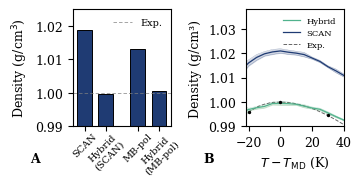

In [ ]:
plt.rcParams.update({
    'font.size': 9, 'legend.fontsize': 7,
    "font.family": "serif",
    })

paletteFessa = [
    '#1F3B73', # dark-blue
    '#2F9294', # green-blue
    '#50B28D', # green
    "#5E9B51",
    '#A7D655', # pisello
    '#FFE03E', # yellow
    '#FFA955', # orange
    '#F4173B', # red
    '#8672AC',
]

# Create figure with grid 1x2
fig = plt.figure(figsize=(3.5, 1.75), constrained_layout=True)
gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 1], wspace=0)  # balanceado

# --- Bar plot ---
ax1 = fig.add_subplot(gs[0, 0])

categorias = ['SCAN', 'Hybrid\n(SCAN)', 'MB-pol', 'Hybrid\n(MB-pol)']
valores = [density_scan, density_hybrid_scan, density_mbpol, density_hybrid_mbpol]

x = [0, 1, 2.5, 3.5]

ax1.bar(x, valores, width=0.7, color=paletteFessa[0], edgecolor='black', linewidth=0.7)
ax1.axhline(y=1.0, linestyle=(0, (5, 3)), color='grey', linewidth=0.5, label='Exp.')

ax1.set_ylabel(r'Density (g/cm$^3$)')
ax1.set_ylim([0.99, 1.025])
ax1.set_yticks([0.99, 1.00, 1.01, 1.02])
ax1.set_xticks(x)
ax1.set_xticklabels(categorias, rotation=45)
ax1.tick_params(axis='x', labelsize=7, pad=0)
ax1.legend(loc='best', frameon=False)

# --- Isobar Densidad Curve ---
ax2 = fig.add_subplot(gs[0, 1])

data_ref_over = np.loadtxt('../training-data/experiment/density/density_nist.txt')
data_ref_under = np.loadtxt('../training-data/experiment/density/density_hare.txt')

density_ref = np.concatenate((data_ref_under[::-1,1], data_ref_over[:,1]/1000)) # from kg/m3 to g/cm3
temperature_ref = np.concatenate((data_ref_under[::-1,0]+273.15, data_ref_over[:,0]))
mask = (temperature_ref >= 252) & (temperature_ref <= 317)
density_ref = density_ref[mask]
temperature_ref = temperature_ref[mask]

tmax_ref = 277.13
tmax = 320
delta_temp = temperatures_hybrid - tmax
ax2.plot(delta_temp, densities_hybrid, color=paletteFessa[2], linewidth=0.9, label='Hybrid')
ax2.plot(delta_temp, densities_hybrid+std_hybrid, color=paletteFessa[2], linewidth=0.25, alpha=0.5)
ax2.plot(delta_temp, densities_hybrid-std_hybrid, color=paletteFessa[2], linewidth=0.25, alpha=0.5)
ax2.fill_between(delta_temp, densities_hybrid-std_hybrid, densities_hybrid+std_hybrid, color=paletteFessa[3], linewidth=0.1, alpha=0.2)

delta_temp_first = temperatures_scan - tmax
ax2.plot(delta_temp_first, densities_scan, color=paletteFessa[0], linewidth=0.9, label='SCAN')
ax2.plot(delta_temp_first, densities_scan+std_scan, color=paletteFessa[0], linewidth=0.25, alpha=0.5)
ax2.plot(delta_temp_first, densities_scan-std_scan, color=paletteFessa[0], linewidth=0.25, alpha=0.5)
ax2.fill_between(delta_temp_first, densities_scan-std_scan, densities_scan+std_scan, color=paletteFessa[0], linewidth=0.1, alpha=0.2)

ax2.plot((temperature_ref-tmax_ref), density_ref, color='black', label='Exp.', linestyle='--', alpha=0.6, linewidth=0.7, zorder=0)

ax2.scatter([-20, 0, 30], [0.9958, 0.9999, 0.9945], color='black', s=2, zorder=5)  # puntos de referencia

ax2.set_xlabel(r'$T - T_\mathrm{MD}$ (K)')
ax2.set_ylabel('Density (g/cm³)')
ax2.set_xlim([-22, 40])
ax2.set_ylim([0.99, 1.038])
ax2.set_xticks([-20, 0, 20, 40])
ax2.set_yticks([0.99, 1.00, 1.01, 1.02, 1.03])
ax2.legend(loc='upper right', frameon=False, fontsize=6)

# --- Labels ---
ax1.text(-0.34, -0.22, 'A', transform=ax1.transAxes,
         va='top', ha='right', weight='bold')

ax2.text(-0.32, -0.22, 'B', transform=ax2.transAxes,
         va='top', ha='right', weight='bold')

plt.show()